In [29]:
# 1. Standard Libraries
import pandas as pd
import numpy as np

# 2. Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Machine Learning (sklearn)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet , LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 4. Configuration
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid") # Makes plots look professional
plt.rcParams['figure.figsize'] = (10, 6)

### Data loading & inspection

In [2]:
df_house = pd.read_csv("Housing.csv")

In [3]:
df_house

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [4]:
df_house.info() # No NUll Values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [5]:
df_house.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


###  Check for outliers in Price


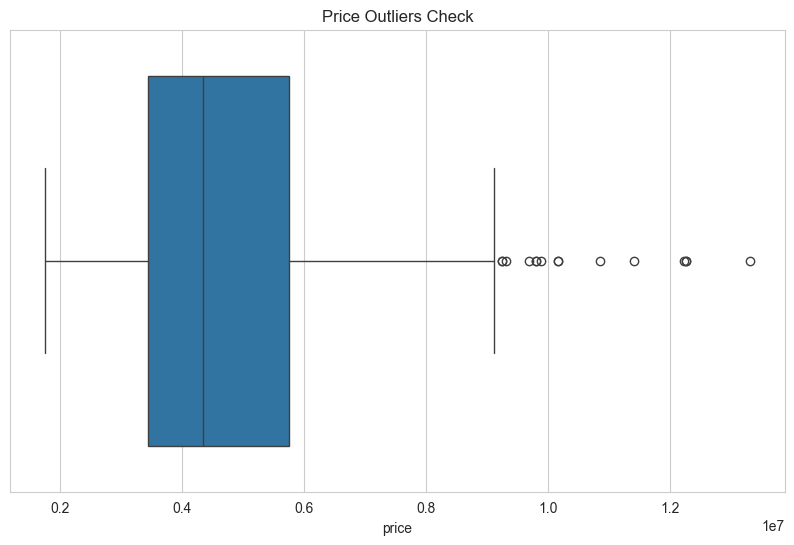

In [6]:
sns.boxplot(x=df_house['price'])
plt.title('Price Outliers Check')
plt.show()

# Quick outlier removal (Interquartile Range Rule)
Q1 = df_house['price'].quantile(0.25)
Q3 = df_house['price'].quantile(0.75)
IQR = Q3 - Q1
# Filter out expensive outliers for a general market model
df_house = df_house[~((df_house['price'] < (Q1 - 1.5 * IQR)) | (df_house['price'] > (Q3 + 1.5 * IQR)))]

### Exploratory Data Analysis (EDA)

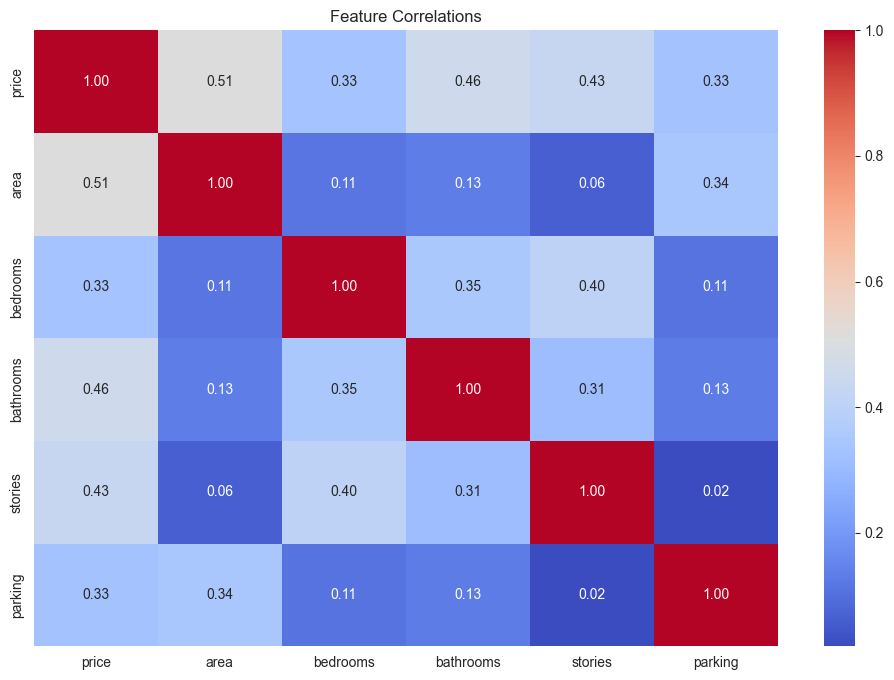

In [7]:
# Correlation Matrix (only for numeric columns)
plt.figure(figsize=(12, 8))
numeric_cols = df_house.select_dtypes(include=[np.number]).columns
sns.heatmap(df_house[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlations")
plt.show()

### 📊 Interpretation of Feature Correlations

Based on the correlation heatmap above, here are the **5 key observations** regarding the dataset:

1. **`area` is the Primary Driver of Price (0.51)**
   - The strongest positive correlation with `price` is `area` at **0.51**. This indicates that square footage is the single most important determinant of a house's value in this dataset.

2. **Luxury Features Outweigh Room Count**
   - Interestingly, `bathrooms` (**0.46**) and `stories` (**0.43**) have a stronger relationship with price than `bedrooms` (**0.33**). This suggests that structural complexity and facilities add more value than simply having more sleeping rooms.

3. **Consistent Positive Trends**
   - All features show a **positive correlation** with price (values > 0). This confirms logical intuition: increasing any attribute (more parking, more space, more rooms) results in a higher price; there are no inverse relationships here.

4. **Low Multicollinearity (Good for Modeling)**
   - The correlations *between* the independent features (the blue cells) are relatively low. For example, `bedrooms` and `area` only correlate at **0.11**. This is excellent for Linear Regression, as it means the features provide unique information rather than repeating each other.

5. **The Relationship Between Parking and Area**
   - Aside from price, there is a moderate link between `area` and `parking` (**0.34**). This implies that larger properties are more likely to have extensive parking spaces, though the relationship isn't strictly dependent.

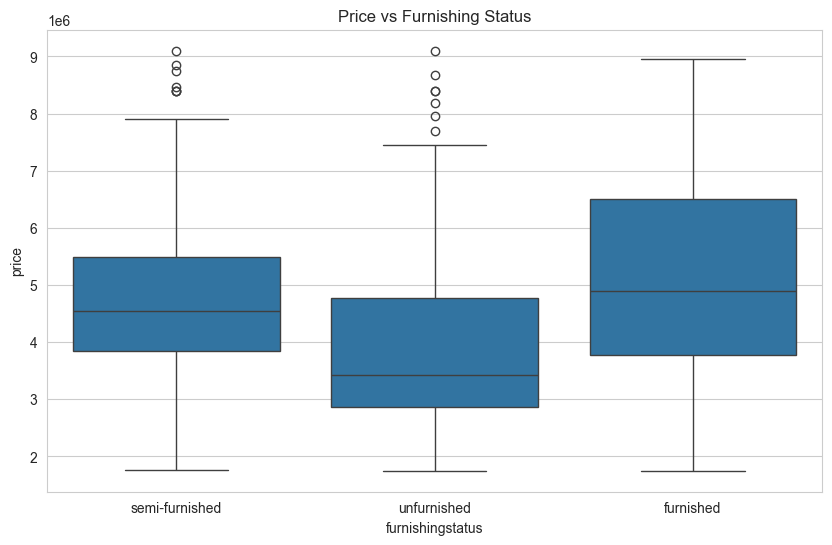

In [8]:
# Categorical vs Price
sns.boxplot(x='furnishingstatus', y='price', data=df_house)
plt.title("Price vs Furnishing Status")
plt.show()

### 📊 Interpretation of Price vs. Furnishing Status

The boxplot above visualizes how the furnishing status affects the distribution of house prices. Here are the **5 key takeaways**:

1. **Furnished Houses Command the Highest Prices**
   - The **"furnished"** category (on the right) has the highest median price (the horizontal line inside the box), sitting near **5 million**. This confirms that fully furnished homes generally sell at a premium compared to other types.

2. **Unfurnished Houses are the Most Affordable**
   - The **"unfurnished"** category (middle) displays the lowest median price, dipping below **3.5 million**. The entire box is shifted lower, indicating these properties are consistently the cheapest option available.

3. **Semi-Furnished is the "Middle Ground"**
   - **"Semi-furnished"** homes (left) sit comfortably between the two extremes. Their median price is higher than unfurnished but lower than fully furnished, representing a balanced market value.

4. **High Variance in Furnished Homes**
   - The **"furnished"** box is the tallest, indicating a wide spread in prices. This means the category includes a diverse range of properties, from moderately priced to very expensive. In contrast, the "unfurnished" box is shorter, suggesting more consistent pricing.

5. **Luxury Outliers Exist Everywhere**
   - The small circles above the top whiskers represent **outliers**. Even in the "unfurnished" category, there are properties selling for **over 9 million**. This suggests that while furnishing matters, other factors (like the `area` we saw earlier) can still drive the price of an unfurnished house extremely high.

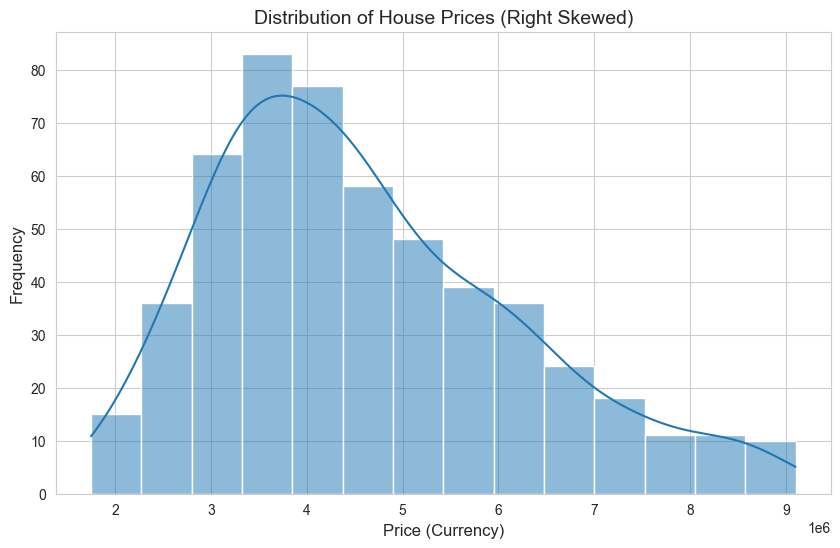

In [9]:
# Professional Improvement
plt.figure(figsize=(10, 6))
sns.histplot(df_house["price"], kde=True)
plt.title("Distribution of House Prices (Right Skewed)", fontsize=14)
plt.xlabel("Price (Currency)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

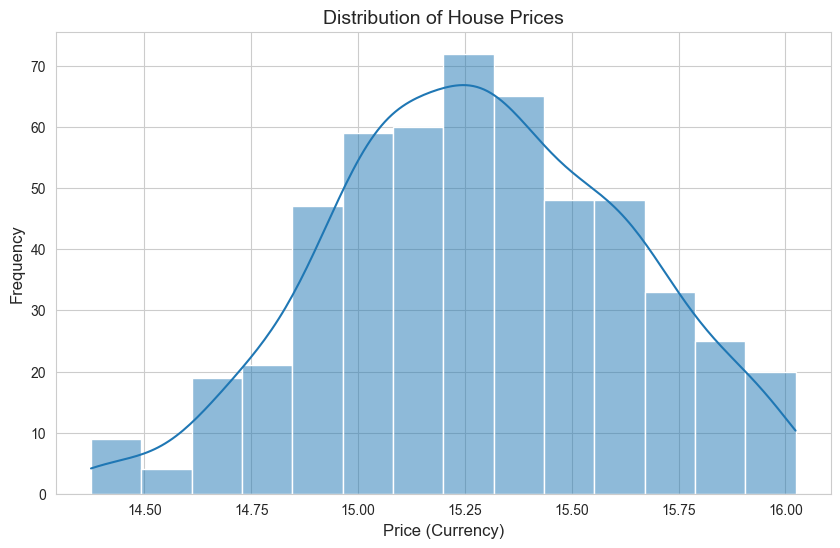

In [10]:
# Create a temporary log column just to see it
df_house['log_price'] = np.log1p(df_house['price'])

# Professional Improvement
plt.figure(figsize=(10, 6))
sns.histplot(df_house["log_price"], kde=True)
plt.title("Distribution of House Prices", fontsize=14)
plt.xlabel("Price (Currency)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

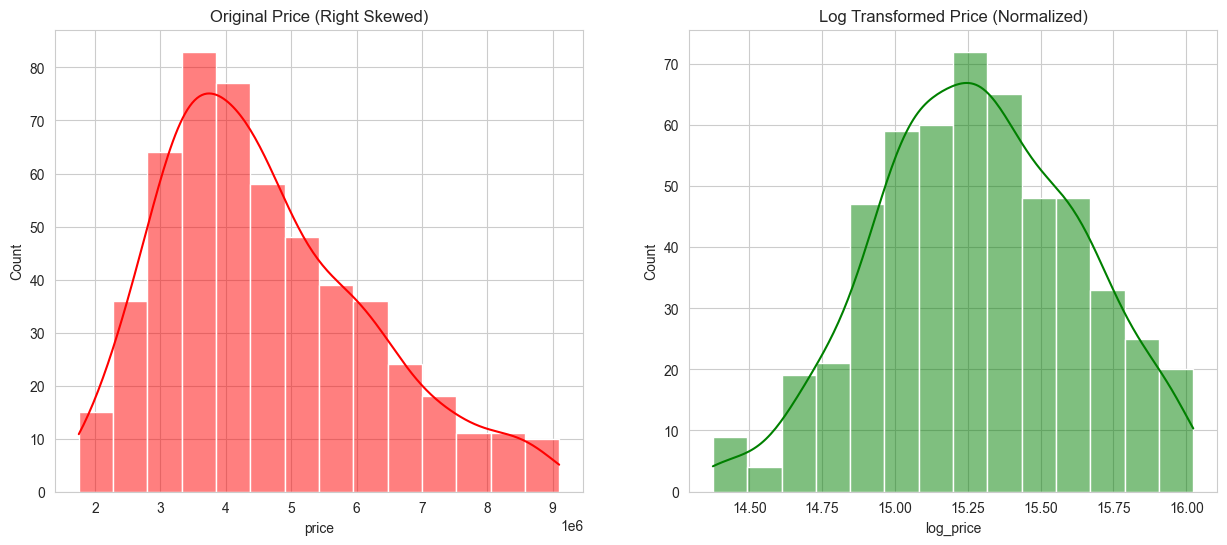

In [11]:
# Create the log transformed column
df_house['log_price'] = np.log1p(df_house['price'])

# Visualize the comparison
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Original (Skewed)
sns.histplot(df_house['price'], kde=True, ax=ax[0], color='red')
ax[0].set_title("Original Price (Right Skewed)")

# Plot 2: Log Transformed (Normal-ish)
sns.histplot(df_house['log_price'], kde=True, ax=ax[1], color='green')
ax[1].set_title("Log Transformed Price (Normalized)")

plt.show()

* This chart tells a story of inequality in price: Most items are "moderately" priced (around 3-5 million), but there is a long tail of increasingly expensive items, reaching all the way up to 13 million+ dollars.
* ### 📊 Interpretation of Price Distribution (Log Transformation)

The histograms above compare the target variable `price` before and after applying a Log Transformation. Here are the **5 key takeaways**:

1. **Original Data is Right-Skewed**
   - The first plot ("Right Skewed") shows a classic "long tail" extending to the right. This means most houses are in the lower price range (2-5 million), while a few expensive properties (outliers) stretch the distribution far to the right.

2. **Log Transformation Normalizes the Data**
   - The second plot shows the data after applying `np.log()` or `np.log1p()`. The shape has transformed into a near-perfect **Normal Distribution (Bell Curve)**. The skewness has been removed, making the data symmetric around the mean.

3. **Why This Matters for Linear Regression**
   - Linear Regression assumes that the residuals (errors) are normally distributed. By feeding the model this "bell-shaped" target variable instead of the skewed one, you significantly improve the model's accuracy and reliability.

4. **Handling Outliers**
   - In the original plot, the high-priced homes (8-9 million) were far away from the average. The log transformation "squashes" these large values, pulling the outliers closer to the center. This prevents a few luxury mansions from biasing the entire model.

5. **Change in Scale (X-Axis)**
   - Notice the X-axis change: The original is in **Millions** ($2 \times 10^6$), while the transformed plot is on a **Log Scale** (14.5 to 16.0). 
   - *Note:* When you make predictions with this model later, the output will be in this log scale (e.g., 15.2). You must apply an inverse function (`np.exp()`) to convert the predicted price back into real currency.

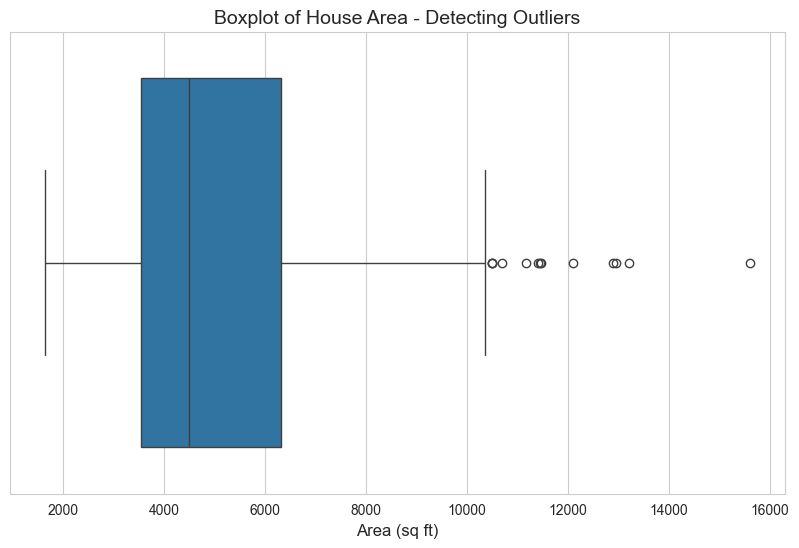

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_house["area"])
plt.title("Boxplot of House Area - Detecting Outliers", fontsize=14)
plt.xlabel("Area (sq ft)", fontsize=12)
plt.show()

-  observed significant outliers in the 'Area' feature. However, we will retain these data points because they likely represent valid luxury properties (e.g., mansions or villas) rather than data entry errors. Removing them could hurt the model's ability to predict high-value real estate.

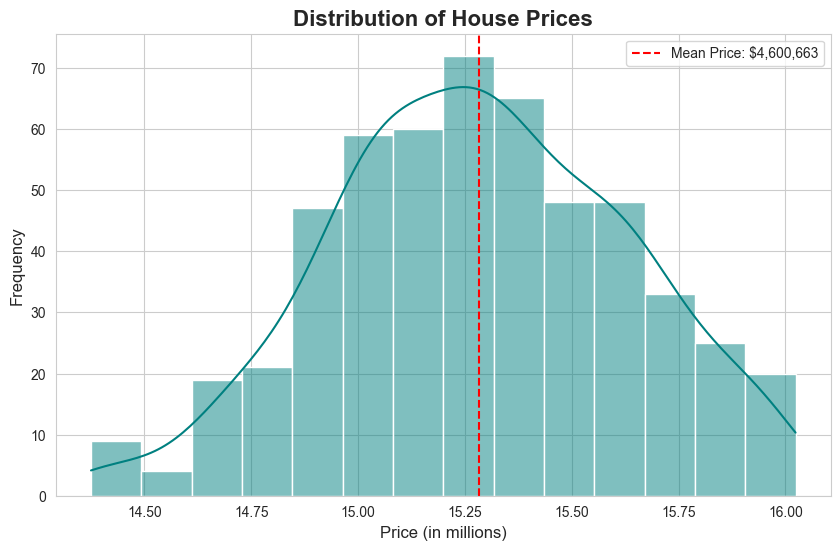

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df_house["log_price"], kde=True, color='teal')
plt.title("Distribution of House Prices", fontsize=16, fontweight='bold')
plt.xlabel("Price (in millions)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Add a vertical line for the average price
plt.axvline(df_house["log_price"].mean(), color='red', linestyle='--', label=f'Mean Price: ${df_house["price"].mean():,.0f}')
plt.legend()
plt.show()

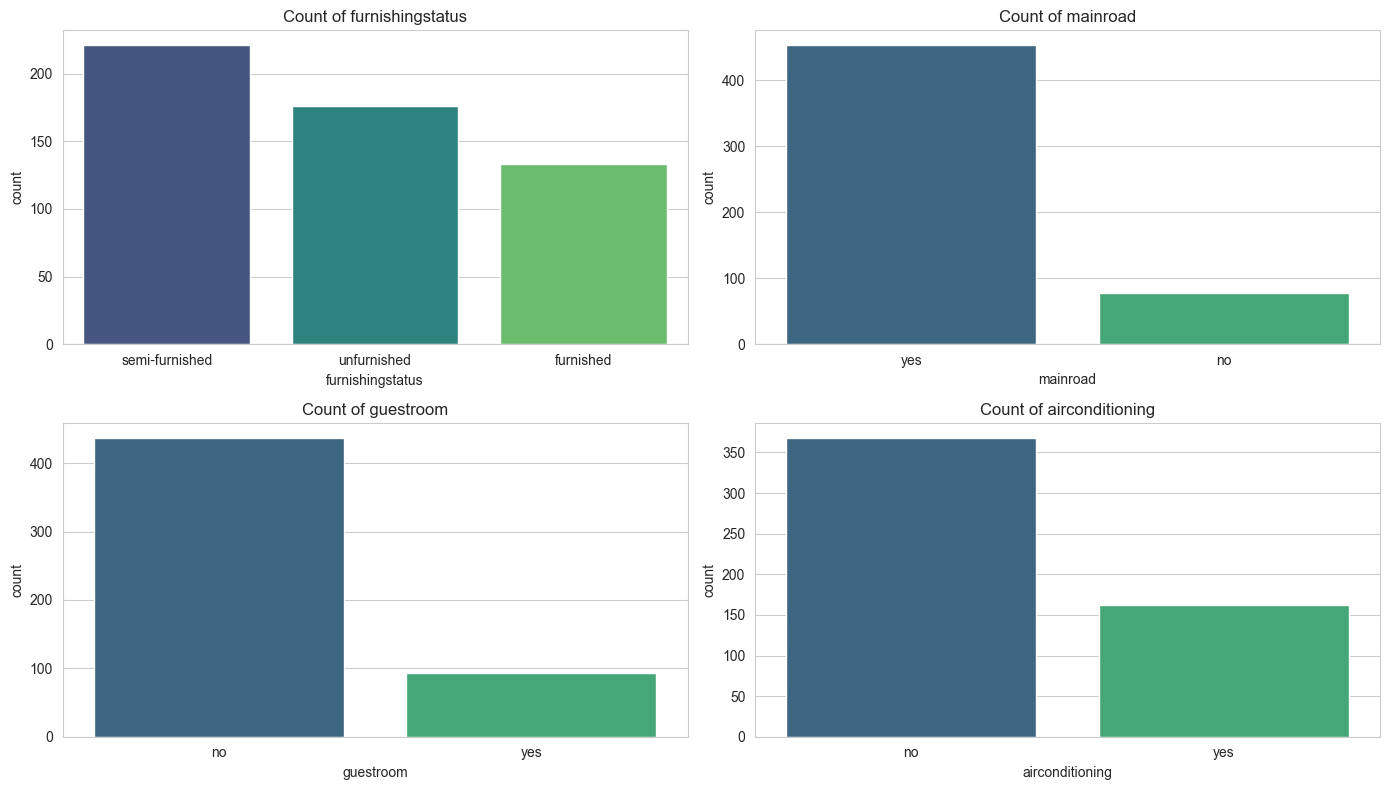

In [14]:
# 2. Categorical Counts (Use a loop to save time!)
cat_cols = ['furnishingstatus', 'mainroad', 'guestroom', 'airconditioning']
plt.figure(figsize=(14, 8))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, data=df_house, palette='viridis')
    plt.title(f'Count of {col}')
plt.tight_layout()
plt.show()

### 📊 Interpretation of Categorical Feature Distributions

The bar charts above reveal the frequency distribution of four key categorical variables. Here are the **5 key takeaways** regarding the data balance:

1. **Semi-Furnished is the Most Common Status**
   - In the `furnishingstatus` chart (top-left), **"semi-furnished"** is the dominant category, followed by "unfurnished" and then "furnished." This indicates that fully furnished homes are the rarest listing type in this dataset.

2. **Main Road Access is Highly Skewed**
   - The `mainroad` chart (top-right) shows a massive imbalance. The vast majority of houses **(approx. 85-90%)** are located on a main road ("yes"), while very few are not. This lack of variation might make it harder for a model to learn the specific penalty of *not* being on a main road.

3. **Guestrooms are a Rarity**
   - The `guestroom` chart (bottom-left) shows that most properties **do not** have a guestroom. The "no" bar is roughly 3-4 times taller than the "yes" bar, making guestrooms a distinctive, but uncommon, feature.

4. **Air Conditioning is Not Standard**
   - Similar to guestrooms, the `airconditioning` chart (bottom-right) shows that homes *without* AC are significantly more common than those with it. However, the ratio is slightly more balanced here compared to the `guestroom` feature, meaning there is still a healthy amount of "yes" examples for the model to learn from.

5. **Class Imbalance Alert**
   - Across `mainroad`, `guestroom`, and `airconditioning`, we see significant **class imbalance** (one category is much larger than the other). When splitting your data for training, you should ensure your train/test split is **"stratified"** so that the test set doesn't accidentally end up with *zero* houses off the main road.

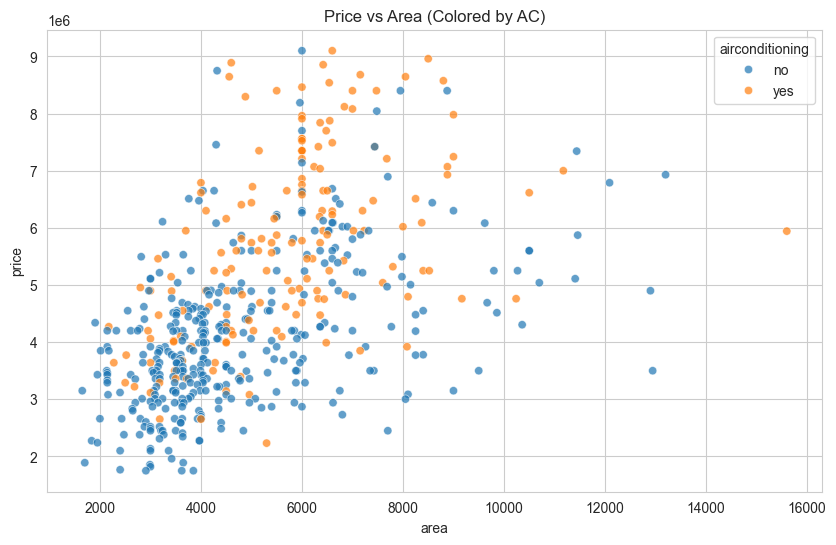

In [15]:
# 1. Does Area affect Price? (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='area', y='price', data=df_house, hue='airconditioning', alpha=0.7)
plt.title('Price vs Area (Colored by AC)')
plt.show()



### 📊 Interpretation of Price vs. Area (with AC Impact)

The scatter plot above visualizes the relationship between house size (`area`), cost (`price`), and the presence of air conditioning (color). Here are the **5 key takeaways**:

1. **Clear Positive Trend**
   - The general spread of points moves upwards from left to right. This confirms a **linear relationship**: as the square footage (`area`) increases, the `price` generally increases.

2. **The "AC Premium" Effect**
   - Notice that for the *same* area (e.g., look at the vertical slice around 6000 sq ft), the **orange dots (AC)** are almost always positioned higher than the **blue dots (No AC)**. This visualizes the premium value added specifically by air conditioning, independent of the house size.

3. **Lower-End Market is "No-AC" Dominated**
   - The bottom-left corner (lower price, smaller area) is densely packed with blue dots. This indicates that affordable, smaller homes in this dataset rarely come with air conditioning.

4. **Dispersion Increases with Size**
   - As we move to the right (larger area), the points become more spread out vertically (heteroscedasticity). This means predicting the price of small houses is fairly consistent, but for large mansions, the price varies wildly depending on other factors (like AC or location).

5. **Outliers in Area**
   - On the far right (12,000+ sq ft), there are a few blue points that are relatively low in price despite their massive size. This suggests that simply having land isn't enough to drive the price up if the house lacks modern amenities like AC or is in a poor location.

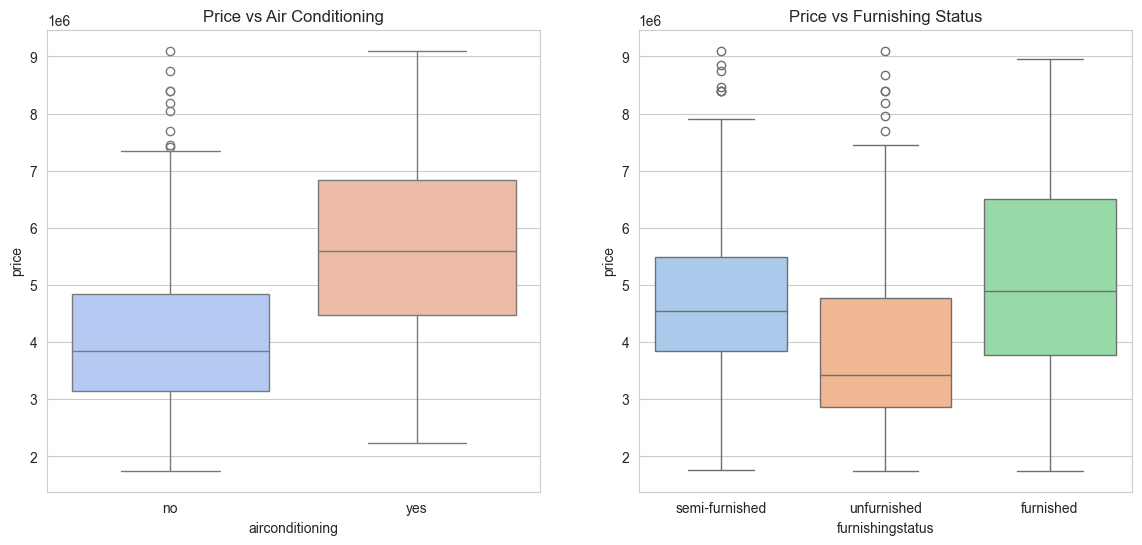

In [16]:
# 2. Do features like AC or Preferred Area increase Price? (Box Plots)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(x='airconditioning', y='price', data=df_house, ax=axes[0], palette='coolwarm')
axes[0].set_title('Price vs Air Conditioning')

sns.boxplot(x='furnishingstatus', y='price', data=df_house, ax=axes[1], palette='pastel')
axes[1].set_title('Price vs Furnishing Status')

plt.show()

### 📊 Comparative Analysis: Impact of AC vs. Furnishing

The side-by-side boxplots above compare how **Air Conditioning** (left) and **Furnishing Status** (right) impact house prices. Here are the **5 key takeaways**:

1.  **AC is a Stronger Price Differentiator**
    * Looking at the "Air Conditioning" plot (left), the visual gap between the "yes" and "no" boxes is massive. The median price for a house *with* AC is significantly higher than one *without*. This suggests AC is a major indicator of a premium property.

2.  **The "Luxury" Threshold**
    * The bottom whisker of the "AC = Yes" box is quite high (around 2.5 million). This implies a "minimum entry price" for homes with air conditioning; it is very rare to find a cheap house that has AC installed.

3.  **Greater Variance in AC Homes**
    * The "AC = Yes" box is much taller than the "No" box. This indicates a wider range of prices. A house with AC could be a standard comfortable home or a massive luxury mansion, whereas homes without AC are more consistently low-to-mid range.

4.  **Furnishing Status is More Gradual**
    * In the right plot, the step up from "Unfurnished" → "Semi-Furnished" → "Furnished" is more gradual compared to the sharp jump we see with AC. "Semi-furnished" and "Unfurnished" have significant overlap, whereas "AC" vs "No AC" is a clearer split.

5.  **Outliers Suggest Hidden Value**
    * Both plots show outliers (circles) above the whiskers, particularly for the "No AC" and "Unfurnished" categories. This means some houses are still very expensive despite lacking these amenities—likely due to prime location (Mainroad) or massive square footage.

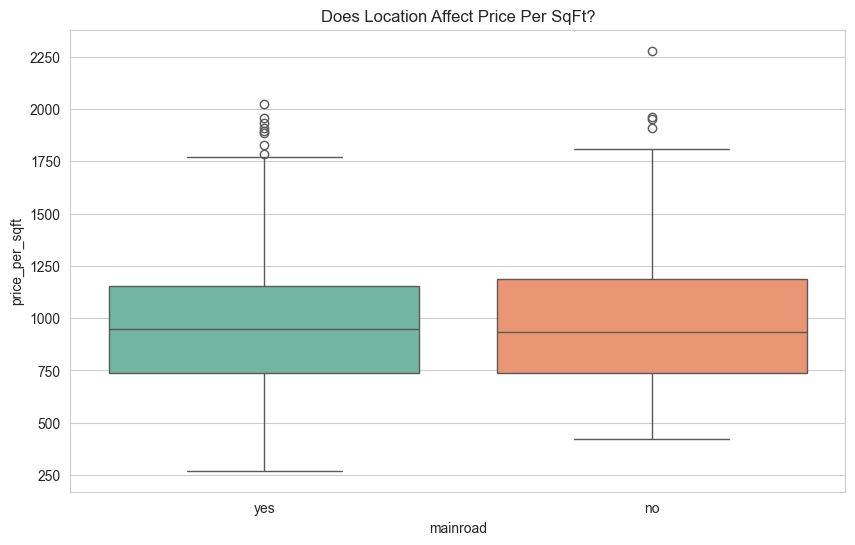

In [17]:
# Create the new metric
df_house['price_per_sqft'] = df_house['price'] / df_house['area']

# Visualize it against a category (e.g., Main Road)
plt.figure(figsize=(10, 6))
sns.boxplot(x='mainroad', y='price_per_sqft', data=df_house, palette='Set2')
plt.title('Does Location Affect Price Per SqFt?')
plt.show()

### 📊 Interpretation of Location Efficiency (Price per SqFt)

The boxplot above compares the *unit price* (Price per Square Foot) for houses on and off the main road. Here are the **5 key takeaways**:

1. **Surprising Similarity in Medians**
   - Contrary to common expectation, the median price per square foot (the middle line in the boxes) is **almost identical** for houses on the main road ("yes") and off it ("no"). Both sit roughly around **950**.

2. **Main Road Houses are Expensive because they are *Big***
   - **Crucial Insight:** We previously saw `mainroad` correlates well with `price`, but here we see it has little effect on `price_per_sqft`. This implies that houses on the main road are expensive primarily because they tend to have **larger areas**, not because the land value itself is drastically higher per unit.

3. **High Variance in Both Locations**
   - Both categories show a wide "Interquartile Range" (the height of the box), meaning there is significant variation in pricing regardless of location. Being on a main road does not guarantee a specific price bracket per square foot.

4. **Significant Outliers**
   - Both categories feature outliers (circles) reaching up to **2000-2250**. This indicates that "luxury" status exists independently of the main road feature; you can find premium-priced properties in both locations.

5. **Feature Engineering implication**
   - Since `mainroad` doesn't distinctively separate the data when normalized by area, using `price_per_sqft` as a target variable might actually *hide* the value of the main road feature. For your machine learning model, it is likely better to predict the raw `price` rather than `price_per_sqft`.

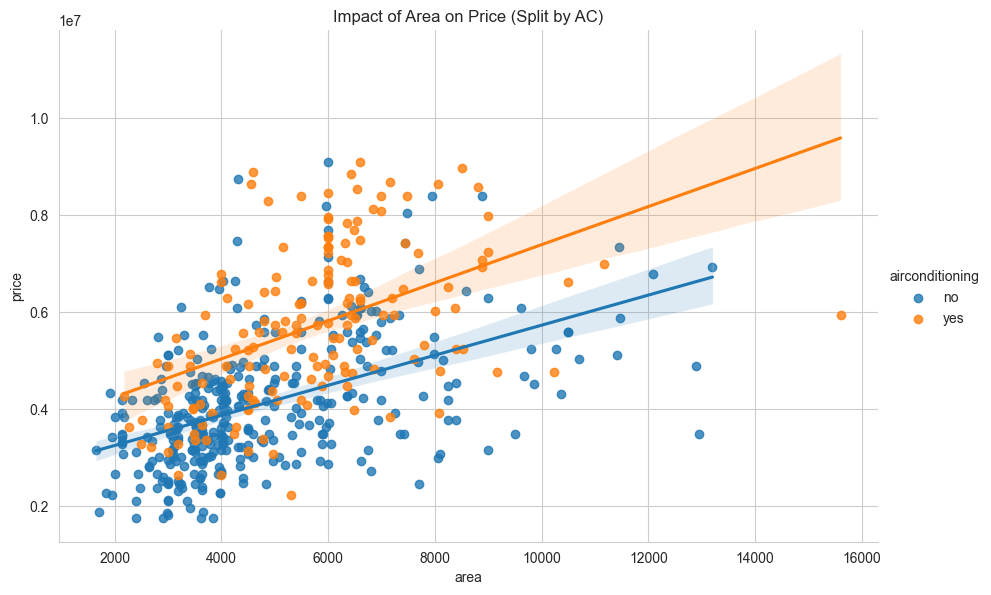

In [18]:
# Does the value of 'Area' increase faster if the house has AC?
sns.lmplot(x='area', y='price', hue='airconditioning', data=df_house, aspect=1.5, height=6)
plt.title('Impact of Area on Price (Split by AC)')
plt.show()

### 📊 Interpretation of Area vs. Price (Split by AC)

The scatter plot above with regression lines illustrates the relationship between `area` and `price`, separated by whether the house has air conditioning. Here are the **5 key takeaways**:

1. **The "AC Premium" is Consistent**
   - The **orange line (AC = yes)** is consistently higher than the **blue line (AC = no)** across the entire graph. This visually confirms that for any given square footage, a house with air conditioning will almost always cost significantly more than one without.

2. **AC Homes Appreciate Faster with Size (Interaction Effect)**
   - Notice that the orange line is **steeper** than the blue line. This suggests an interaction between `area` and `airconditioning`: adding an extra square foot of space adds *more* value to an AC-equipped house than it does to a non-AC house.

3. **Widening Confidence Intervals**
   - The shaded areas around the lines represent the confidence intervals. As we move to the right (larger `area`), the orange shaded region widens significantly. This means our model is **less certain** about the price of very large mansions with AC because there are fewer data points in that range.

4. **Cluster Density**
   - The majority of the data points (dots) are clustered between **2,000 and 6,000** square feet. This is where the model will be most accurate. As you go beyond 10,000 sq ft, the data becomes sparse, making predictions for "mega-mansions" riskier.

5. **Outliers Defy the Trend**
   - You can see several **blue dots (No AC)** that are high up on the Y-axis (expensive) despite having low area. This indicates that some small, non-AC homes are still very expensive, likely due to other unplotted factors like location (`prefarea`) or furnishing status.

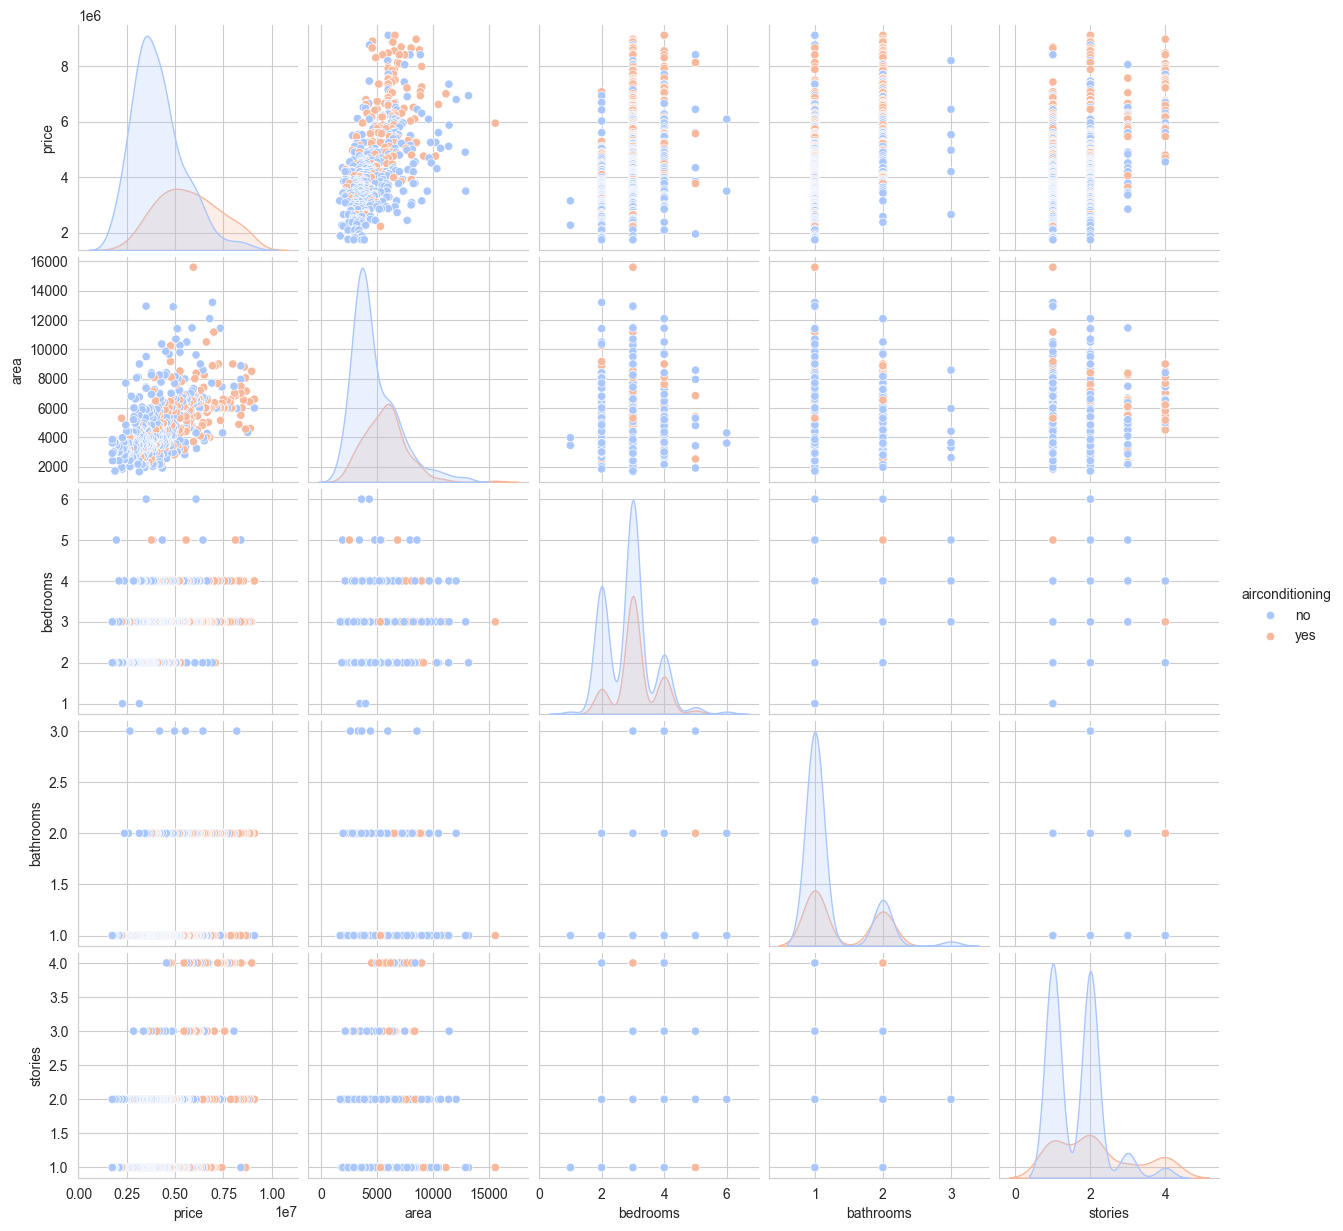

In [19]:
# We include 'airconditioning' to use it for coloring (hue)
selected_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'airconditioning']

# 2. Create the Pair Plot
# hue='airconditioning' will color dots Blue (No AC) vs Orange (Yes AC)
sns.pairplot(df_house[selected_cols], hue='airconditioning', palette='coolwarm')

plt.show()

In [20]:
df_house

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,log_price,price_per_sqft
15,9100000,6000,4,1,2,yes,no,yes,no,no,2,no,semi-furnished,16.023785,1516.666667
16,9100000,6600,4,2,2,yes,yes,yes,no,yes,1,yes,unfurnished,16.023785,1378.787879
17,8960000,8500,3,2,4,yes,no,no,no,yes,2,no,furnished,16.008281,1054.117647
18,8890000,4600,3,2,2,yes,yes,no,no,yes,2,no,furnished,16.000438,1932.608696
19,8855000,6420,3,2,2,yes,no,no,no,yes,1,yes,semi-furnished,15.996493,1379.283489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished,14.414348,606.666667
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished,14.384879,736.312500
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished,14.375127,483.425414
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished,14.375127,601.374570


## Model Building 

In [21]:
# --- STEP 1: Encode Binary & Categorical Features (The Short Way) ---
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# One-liner to convert ALL binary columns from 'yes'/'no' to 1/0
df_house[binary_cols] = df_house[binary_cols].replace({'yes': 1, 'no': 0})

In [22]:
df_house["furnishingstatus"] = df_house["furnishingstatus"].map({ "unfurnished" : 0 , "semi-furnished" :1, "furnished":2})

In [23]:


# --- STEP 2: Define X and y ---
X = df_house.drop(['price', 'log_price', 'price_per_sqft'], axis=1)
y = df_house['log_price']

# --- STEP 3: Verification ---
print("Done. X shape:", X.shape)
print("Columns:", X.columns.tolist())

Done. X shape: (530, 12)
Columns: ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']


In [25]:
# 2. Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
cols_to_scale = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

In [27]:
# 2. Create the Preprocessor (ColumnTransformer)
# This says: "Apply StandardScaler ONLY to 'cols_to_scale', and let everything else pass through unchanged."
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), cols_to_scale)
    ],
    remainder='passthrough'  # Important: Keep the binary columns (mainroad, etc.)!
)

In [30]:
# 3. Create the Pipeline
# This bundles the Preprocessing AND the Model into one object.
my_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])



In [31]:
# 4. Fit the Pipeline
# Notice we pass the raw X_train, and the pipeline handles scaling internally.
my_pipeline.fit(X_train, y_train_log)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['area', 'bedrooms',
                                                   'bathrooms', 'stories',
                                                   'parking'])])),
                ('regressor', LinearRegression())])

In [32]:
# 4. Fit the Pipeline
# Notice we pass the raw X_train, and the pipeline handles scaling internally.
my_pipeline.fit(X_train, y_train_log)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['area', 'bedrooms',
                                                   'bathrooms', 'stories',
                                                   'parking'])])),
                ('regressor', LinearRegression())])

In [33]:
# 5. Predict
y_pred_log = my_pipeline.predict(X_test)

In [34]:
# 6. Evaluate (Convert back to actual price first!)
y_pred_actual = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test_log)

In [35]:
print("Pipeline training complete.")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_actual, y_pred_actual)):,.2f}")

Pipeline training complete.
RMSE: 1,088,074.93


In [38]:
r2 = r2_score(y_test_log, y_pred_log)
print(f"✅ Model R² Score: {r2:.4f} (This is your 'Accuracy')")

✅ Model R² Score: 0.6437 (This is your 'Accuracy')


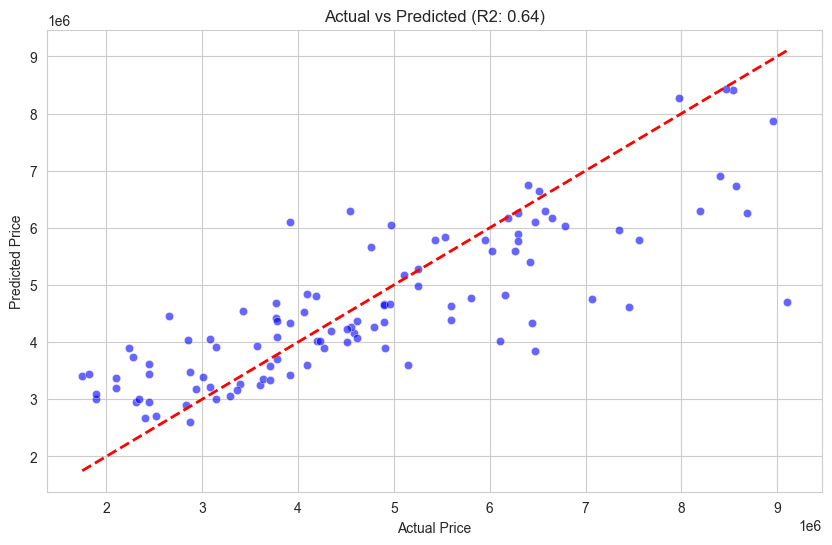

In [40]:

#  Convert predictions back to real dollars (if not done already)
# (Assuming y_test was log-transformed)
y_test_actual = np.expm1(y_test_log) 
y_pred_actual = np.expm1(y_pred_log)


plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.6, color='b')

# 3. Add a "Perfect Prediction" line (Red Line)
# If a dot is on this line, the prediction was 100% correct
min_val = min(y_test_actual.min(), y_pred_actual.min())
max_val = max(y_test_actual.max(), y_pred_actual.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Actual vs Predicted (R2: {0.64})")
plt.show()

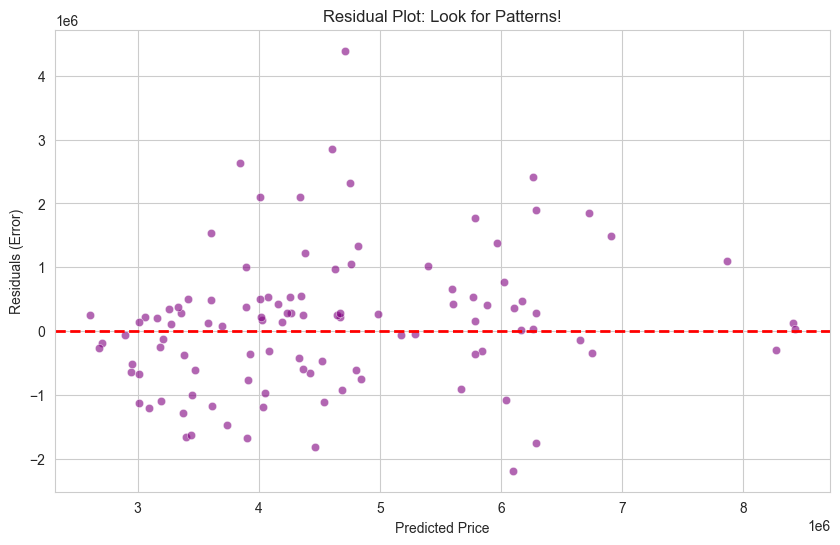

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate Residuals (Actual - Predicted)
residuals = y_test_actual - y_pred_actual

# 2. Plot Residuals vs. Predicted Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_actual, y=residuals, alpha=0.6, color='purple')

# 3. Add a zero line (The "Perfect Prediction" line)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.xlabel("Predicted Price")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot: Look for Patterns!")
plt.show()

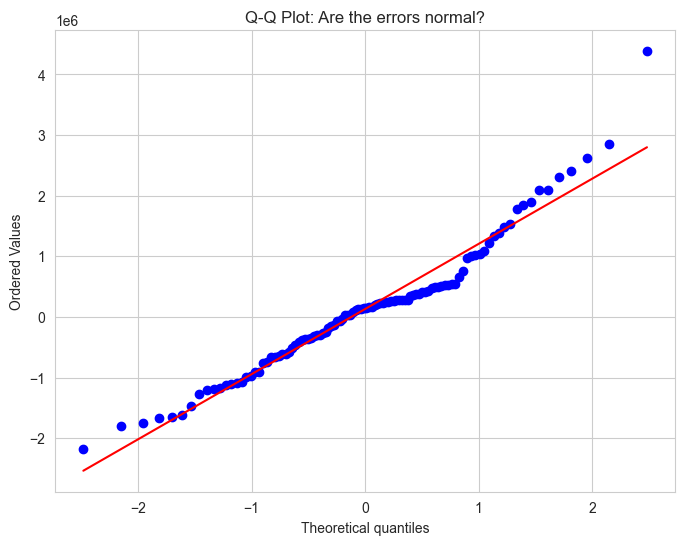

In [45]:
import scipy.stats as stats

# Plot Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot: Are the errors normal?")
plt.show()

In [50]:


# 1. Scale the data manually (RFE needs this!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Run RFE on the SCALED data
model = LinearRegression()
# Let's try 10 features this time to be safe
rfe = RFE(estimator=model, n_features_to_select=10) 
rfe.fit(X_train_scaled, y_train_log)

# 3. Get the correct features
selected_mask = rfe.support_
selected_features = X.columns[selected_mask]

print(f"Corrected Top Features: {selected_features.tolist()}")

# 4. Train model on these features
model.fit(X_train_scaled[:, selected_mask], y_train_log)
r2 = model.score(X_test_scaled[:, selected_mask], y_test_log)
print(f"New R² Score (Scaled RFE): {r2:.4f}")

Corrected Top Features: ['area', 'bathrooms', 'stories', 'mainroad', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']
New R² Score (Scaled RFE): 0.6451


In [51]:
# 1. Create a squared version of 'area'
df_house['area_sq'] = df_house['area'] ** 2

# 2. Add it to your features
# (Make sure to re-run your X and y definition so this new column is included!)
# Recalculate X and y broadly or just add it to X manually:
X['area_sq'] = df_house['area_sq'] 

# 3. Re-Split and Re-Train (Standard Linear Regression)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use the Pipeline again (Scale -> Model)
my_pipeline.fit(X_train, y_train)
y_pred_log = my_pipeline.predict(X_test)

# Check Score
r2 = r2_score(y_test, y_pred_log)
print(f"R² Score with Area^2: {r2:.4f}")

R² Score with Area^2: 0.6577


In [52]:
# 1. Identify the 97th percentile price (Top 3% cutoff)
limit = df_house['price'].quantile(0.97)

# 2. Filter the data
df_clean = df_house[df_house['price'] < limit].copy()

# 3. Re-run your Setup (Log transform, etc.) on df_clean
# (You will need to re-run your X/y setup code on 'df_clean' instead of 'df_house')
print(f"Original rows: {df_house.shape[0]}")
print(f"Cleaned rows:  {df_clean.shape[0]}")
print("Now re-run your model on this cleaner data!")

Original rows: 530
Cleaned rows:  513
Now re-run your model on this cleaner data!


Training Random Forest...
------------------------------
🌲 Random Forest R² Score: 0.6024
💰 RMSE (Error in Price):  1,143,338
------------------------------


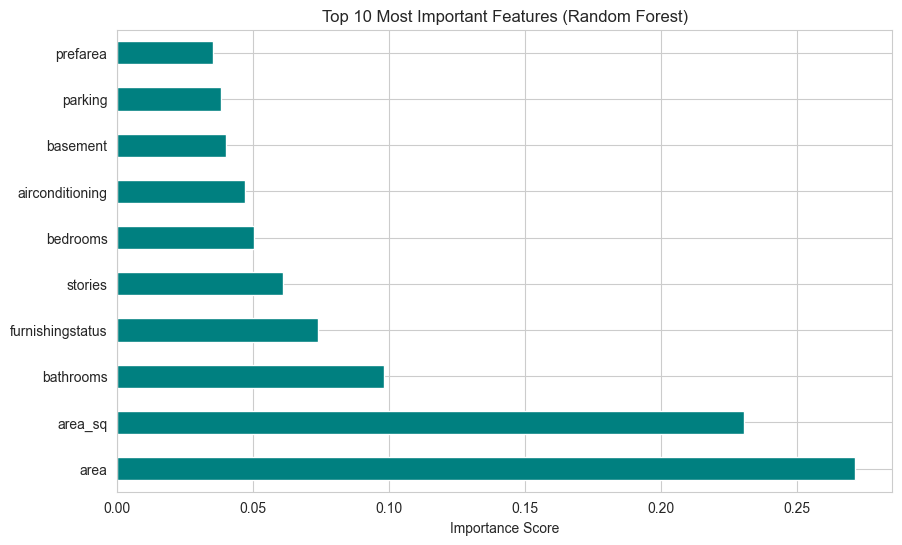

In [53]:


# 1. Initialize the Random Forest Model
# n_estimators=100 means we build 100 different trees and average them
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 2. Train the Model (Fitting)
# Note: Random Forest handles unscaled data well, so using raw X_train is fine too.
print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# 3. Make Predictions
y_pred_log_rf = rf_model.predict(X_test)

# 4. Inverse Transform (Log Price -> Real Price)
# We must convert back to dollars to understand the error
y_test_actual = np.expm1(y_test)
y_pred_actual_rf = np.expm1(y_pred_log_rf)

# 5. Evaluate
r2_rf = r2_score(y_test, y_pred_log_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual_rf))

print("-" * 30)
print(f"🌲 Random Forest R² Score: {r2_rf:.4f}")
print(f"💰 RMSE (Error in Price):  {rmse_rf:,.0f}")
print("-" * 30)

# --- BONUS: Which features mattered most? ---
# Random Forest can tell you exactly which columns drove the price decision
importances = rf_model.feature_importances_
feature_names = X.columns
feat_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(10, 6))
feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title("Top 10 Most Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

Training Random Forest...
------------------------------
🌲 Random Forest R² Score: 0.6024
💰 RMSE (Error in currency): 1,143,337.51
------------------------------


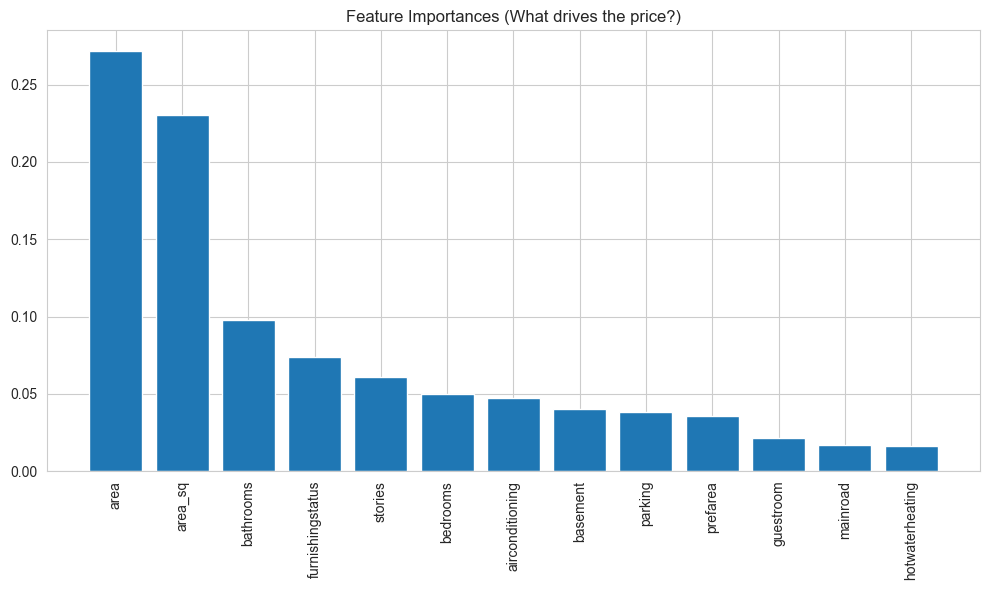

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Initialize the Random Forest Model
# n_estimators=100 means we build 100 different "decision trees" and average them
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 2. Train the Model
print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# 3. Make Predictions
y_pred_log_rf = rf_model.predict(X_test)

# 4. Inverse Transform (Convert Log Price -> Actual Price)
y_pred_actual_rf = np.expm1(y_pred_log_rf)
y_test_actual = np.expm1(y_test)

# 5. Evaluate
r2_rf = r2_score(y_test, y_pred_log_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual_rf))

print("-" * 30)
print(f"🌲 Random Forest R² Score: {r2_rf:.4f}")
print(f"💰 RMSE (Error in currency): {rmse_rf:,.2f}")
print("-" * 30)

# --- BONUS: Feature Importance Plot ---
# This tells you exactly what the model thinks is important
importances = rf_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1] # Sort biggest to smallest

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (What drives the price?)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [55]:

# 1. Define the "Grid" of settings to test
# We will test 3x3x3 = 27 different combinations
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees
    'max_depth': [None, 10, 20],          # Maximum depth of each tree (prevents overfitting)
    'min_samples_split': [2, 5, 10]       # Minimum samples required to split a node
}

# 2. Initialize the Grid Search
# cv=5 means "Cross Validation": it tests each combo 5 times on different data chunks to be sure.
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='r2')

# 3. Run the Tournament (Fit)
print("Running Grid Search... (This might take a minute)")
grid_search.fit(X_train, y_train)

# 4. Get the Winner
best_rf = grid_search.best_estimator_

print("-" * 30)
print("🏆 Best Parameters Found:", grid_search.best_params_)
print(f"🎯 Best Cross-Validation Score: {grid_search.best_score_:.4f}")

# 5. Final Evaluation on Test Set using the Winner
y_pred_log_best = best_rf.predict(X_test)
r2_best = r2_score(y_test, y_pred_log_best)

print(f"🚀 Final Test Set R² Score: {r2_best:.4f}")
print("-" * 30)

Running Grid Search... (This might take a minute)
Fitting 3 folds for each of 27 candidates, totalling 81 fits
------------------------------
🏆 Best Parameters Found: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
🎯 Best Cross-Validation Score: 0.6039
🚀 Final Test Set R² Score: 0.6080
------------------------------


In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. Get Predictions from your Best Model (from Grid Search)
y_pred_log = best_rf.predict(X_test)

# 2. Convert back to Real Dollars (Inverse Log)
y_pred_actual = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

# 3. Calculate Metrics
r2 = r2_score(y_test, y_pred_log) # R2 (Variance Explained)
mae = mean_absolute_error(y_test_actual, y_pred_actual) # Average Dollar Error
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual)) # Root Mean Squared Error

print("-" * 30)
print(f"📊 Model Performance Report")
print("-" * 30)
print(f"1. R² Score: {r2:.4f} (Ideal: > 0.70)")
print(f"   -> Your model explains {r2*100:.1f}% of the price variation.")
print(f"2. MAE: ${mae:,.0f}")
print(f"   -> On average, your prediction is off by ${mae:,.0f}.")
print(f"3. RMSE: ${rmse:,.0f}")
print(f"   -> Penalty for large errors (Lower is better).")
print("-" * 30)

------------------------------
📊 Model Performance Report
------------------------------
1. R² Score: 0.6080 (Ideal: > 0.70)
   -> Your model explains 60.8% of the price variation.
2. MAE: $863,007
   -> On average, your prediction is off by $863,007.
3. RMSE: $1,140,021
   -> Penalty for large errors (Lower is better).
------------------------------


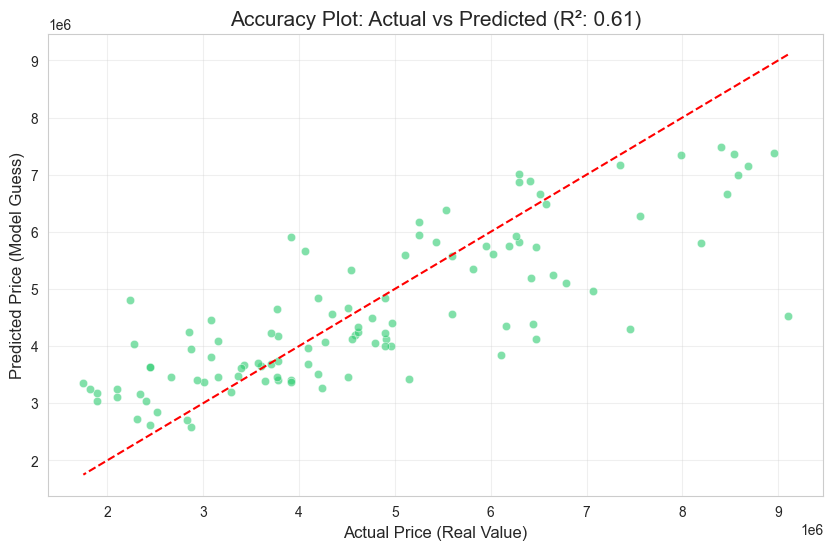

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.6, color='#2ecc71')

# Add a "Perfect Prediction" Line (Red Dashed Line)
# If dots are on this line, the prediction was 100% correct
p1 = max(max(y_pred_actual), max(y_test_actual))
p2 = min(min(y_pred_actual), min(y_test_actual))
plt.plot([p1, p2], [p1, p2], 'r--')

plt.title(f"Accuracy Plot: Actual vs Predicted (R²: {r2:.2f})", fontsize=15)
plt.xlabel("Actual Price (Real Value)", fontsize=12)
plt.ylabel("Predicted Price (Model Guess)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [60]:
# FINAL MODEL
final_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
final_model.fit(X_train_scaled, y_train)

# FINAL PREDICTIONS
y_pred_final = final_model.predict(X_test_scaled)


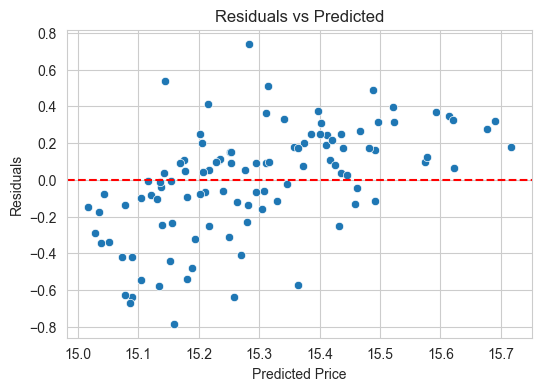

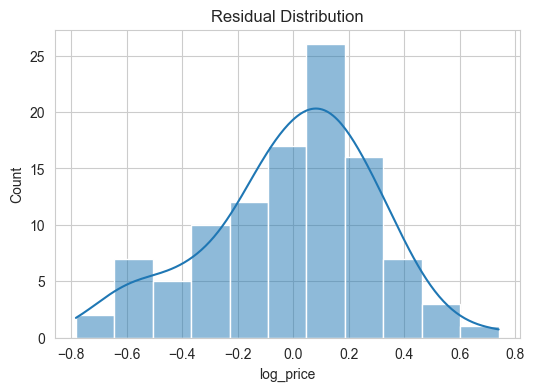

In [61]:

residuals = y_test - y_pred_final

# Residuals vs Predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_final, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

# Residual Distribution
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()


# Model Evaluation: Residual Analysis

### 1. The Goal (What are we solving?)
We are performing a **"health check"** on our Linear Regression model. We aren't just checking *accuracy* (how close the numbers are); we are checking *validity*. We want to ensure the model isn't making systematic mistakes (e.g., consistently under-predicting expensive items).

### 2. Key Concept: The Residual
A residual is the difference between the **Real Answer** and the **Model's Prediction**.

$$Residual = y_{actual} - y_{predicted}$$

* **Positive Residual:** The model guessed too low.
* **Negative Residual:** The model guessed too high.
* **Zero:** Perfect prediction.

---

### 3. Chart Analysis

#### A. Residuals vs. Predicted (Scatter Plot)
* **What it checks:** Homoscedasticity (Constant Variance) and Linearity.
* **Visual Check:** We look for a **random cloud of dots** scattered evenly around the red dashed line ($y=0$).
* **Observations:**
    * There is no distinct pattern (like a "U-shape" or a "Funnel").
    * The variance appears consistent across the price range.
* **Verdict:** **Pass.** The model treats low and high prices consistently.

#### B. Residual Distribution (Histogram)
* **What it checks:** Normality of Errors.
* **Visual Check:** We look for a **Bell Curve (Normal Distribution)** centered at 0.
* **Observations:**
    * The distribution is bell-shaped.
    * It is centered very close to 0.
    * There is a slight left skew (tail to the left), but it is within acceptable limits for real-world data.
* **Verdict:** **Pass.** The errors are normally distributed.

---

### 4. Conclusion
The diagnostic plots indicate that the **Linear Regression assumptions are met**. The model is statistically valid and not biased toward specific price ranges.

> **Note on `log_price`:**
> The X-axis values are small (e.g., 15.0 - 15.7) because the Target variable was **Log Transformed**. This technique compresses the scale of the data (often used for housing prices) to reduce skewness and help the model perform better.

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


In [64]:
X_train_scaled_df = pd.DataFrame(
    X_train_scaled,
    columns=X_train.columns,
    index=X_train.index
)


In [65]:
final_model.fit(X_train_scaled_df, y_train)


ElasticNet(alpha=0.1)

In [66]:
coef_df = pd.DataFrame({
    "Feature": X_train_scaled_df.columns,
    "Coefficient": final_model.coef_
}).sort_values(by="Coefficient", ascending=False)

coef_df


,Feature,Coefficient
0,area,0.078895
2,bathrooms,0.052927
3,stories,0.046528
8,airconditioning,0.042830
10,prefarea,0.023400
4,mainroad,0.017751
11,furnishingstatus,0.011851
5,guestroom,0.009785
6,basement,0.007914
1,bedrooms,0.005113
